# Preprocess Continuous Data - Resting State
## MS023
02/26/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
subj_id = 'MS023'

# Specify root directory for data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg/'
anat_dir = f'{base_dir}anat'
neural_dir = f'{base_dir}preprocess/raw_data/{subj_id}'
save_dir = f'{base_dir}preprocess/clean_data/{subj_id}'
os.makedirs(save_dir,exist_ok = True)

#### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
mne_data

<RawEDF | MS023_Resting_iEEG.edf, 276 x 621056 (606.5 s), ~1.28 GB, data loaded>

In [6]:
mne_data.ch_names

['LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LmOIF10',
 'RmOIF1',
 'RmOIF2',
 'RmOIF3',
 'RmOIF4',
 'RmOIF5',
 'RmOIF6',
 'RmOIF7',
 'RmOIF8',
 'RmOIF9',
 'RmOIF10',
 'RmOIF11',
 'RmOIF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RAgIT9',
 'RAgIT10',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT

# Import Anat Recon Info - check all elecs are present in data + recon sheet


In [7]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs = elec_locs.dropna(axis=0, how = 'all')
elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-7.138108,46.161049,-3.444031,-5.341205,36.652858,-4.752700,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,Lesion,NaN
1,LaCaS2,A32sg_L,-8.336180,48.159363,1.347014,-6.815569,39.035486,0.768345,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,Lesion,NaN
2,LaCaS3,A32sg_L,-9.933610,49.758014,6.138059,-8.771415,41.176625,6.284039,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,Lesion,NaN
3,LaCaS4,A32p_L,-10.732326,51.356665,10.130596,-9.864238,43.161441,10.914484,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left cingulate gyrus F,Lesion,NaN
4,LaCaS5,A10m_L,-12.329756,53.354978,14.921641,-11.561478,45.628978,16.511282,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left frontal pole 4 A,Lesion,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,RpCSMA6,Unknown,17.622061,10.591066,51.253730,18.456702,3.241802,58.019679,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,Unknown,Right superior frontal gyrus 6 D,NaN,NaN
170,RpCSMA7,A6dl_R,19.618849,11.790054,55.645521,20.319866,4.388810,63.109609,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 6 D,NaN,NaN
171,RpCSMA8,A6dl_R,21.615637,12.589380,60.037312,22.209713,5.074195,68.159479,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 6 D,NaN,NaN
172,RpCSMA9,Unknown,23.612424,13.788368,64.429103,24.123840,6.203477,73.329569,Unknown,Unknown,Unknown,Unknown,Unknown,Right superior frontal gyrus 7 E,OOB,NaN


### Fix edf channel names

In [8]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [9]:
unmatched_names

[]

In [10]:
unmatched_seeg

[]

In [11]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
new_name_dict

{'LmOIF1': 'lmoif1',
 'LmOIF2': 'lmoif2',
 'LmOIF3': 'lmoif3',
 'LmOIF4': 'lmoif4',
 'LmOIF5': 'lmoif5',
 'LmOIF6': 'lmoif6',
 'LmOIF7': 'lmoif7',
 'LmOIF8': 'lmoif8',
 'LmOIF9': 'lmoif9',
 'LmOIF10': 'lmoif10',
 'RmOIF1': 'rmoif1',
 'RmOIF2': 'rmoif2',
 'RmOIF3': 'rmoif3',
 'RmOIF4': 'rmoif4',
 'RmOIF5': 'rmoif5',
 'RmOIF6': 'rmoif6',
 'RmOIF7': 'rmoif7',
 'RmOIF8': 'rmoif8',
 'RmOIF9': 'rmoif9',
 'RmOIF10': 'rmoif10',
 'RmOIF11': 'rmoif11',
 'RmOIF12': 'rmoif12',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'racas11',
 'RaCaS12': 'racas12',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3

In [12]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS023_Resting_iEEG.edf, 276 x 621056 (606.5 s), ~1.28 GB, data loaded>

In [13]:
unmatched_seeg #make sure there are no unmatched names

[]

In [14]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) 
#print extra channels in mne_data.ch_names and make sure none of them are neural channels


['c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [15]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 94 left & 80 right sEEG electrodes
We have a total of 174 sEEG electrodes


In [16]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS023_Resting_iEEG.edf, 174 x 621056 (606.5 s), ~824.6 MB, data loaded>

In [17]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS023_Resting_iEEG.edf, 174 x 621056 (606.5 s), ~824.6 MB, data loaded>

In [19]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS023_Resting_iEEG.edf, 174 x 621056 (606.5 s), ~824.7 MB, data loaded>

### Notch filter line noise

In [20]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:    2.4s finished


<RawEDF | MS023_Resting_iEEG.edf, 174 x 621056 (606.5 s), ~824.7 MB, data loaded>

### Resampling data 

In [21]:
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    3.3s finished


<RawEDF | MS023_Resting_iEEG.edf, 174 x 303250 (606.5 s), ~402.8 MB, data loaded>

### Bad Channel Removal (manual)

Let's pick out any bad channels missed by automatic screening (visual inspection as a reference), or restore channels that were erroneously deemed bad. You have to press the "power" button twice (once for the plot and once for the panel beneath it) when you're done so that you're manual changes are saved.

In [5]:
# mne_data = mne.io.read_raw_fif(f'{save_dir}/{subj_id}_raw_ieeg.fif', preload=True)

<IPython.core.display.Javascript object>


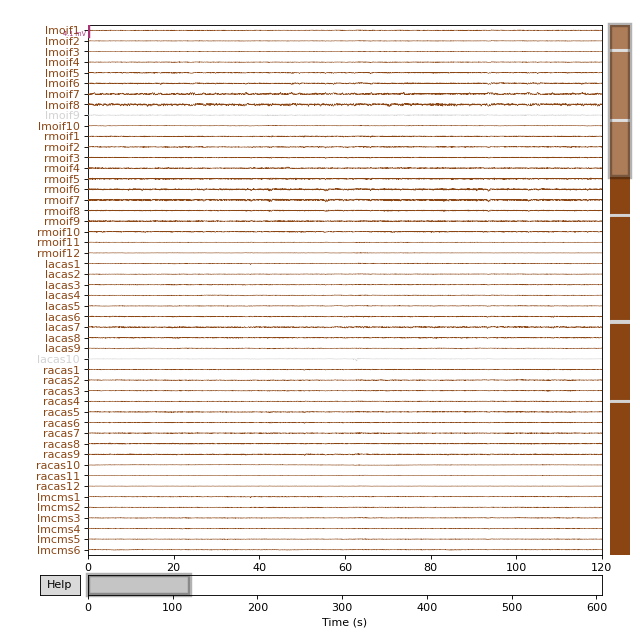

<IPython.core.display.Javascript object>


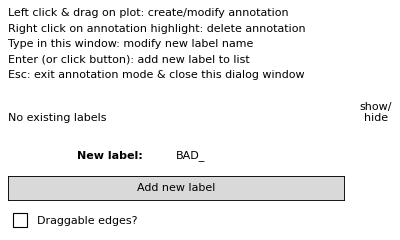

In [34]:
%matplotlib notebook


fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/5)
fig.fake_keypress('a') #lots of bad times 

In [35]:
mne_data.info['bads'] #sanity check that bads info saved


['lhpit12', 'lcmpo14', 'rmcms9', 'lacas10', 'lmoif9']

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [36]:
mne_data.save(f'{save_dir}/{subj_id}_raw_ieeg.fif',overwrite=True)

# Rereference data 

To start annotating, press 'Add new label' in the bottom panel. Then left click and drag around window of interest. 

In [37]:
# Re-reference neural data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]

mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

<IPython.core.display.Javascript object>


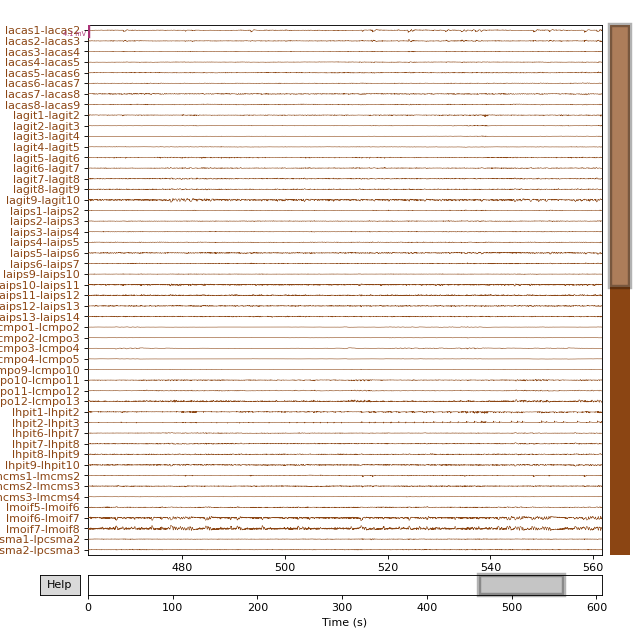

<IPython.core.display.Javascript object>


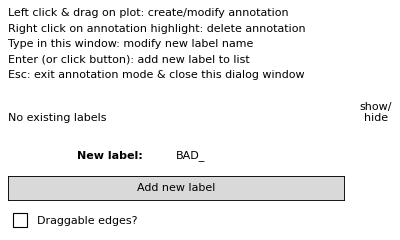

In [40]:
%matplotlib notebook

fig = mne_data_bp_reref.plot(start=2, duration=100, n_channels=50,scalings=mne_data._data.max()/5 ) # plot all channels at once
fig.fake_keypress("a")


<IPython.core.display.Javascript object>


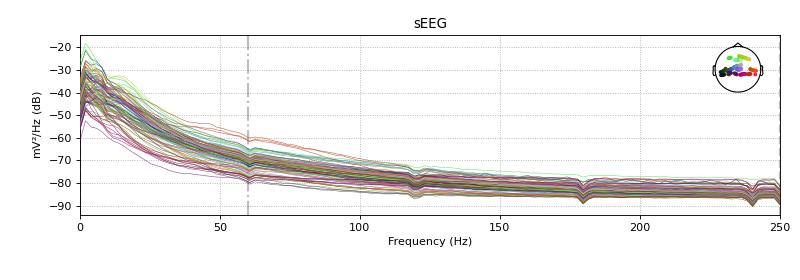

<IPython.core.display.Javascript object>


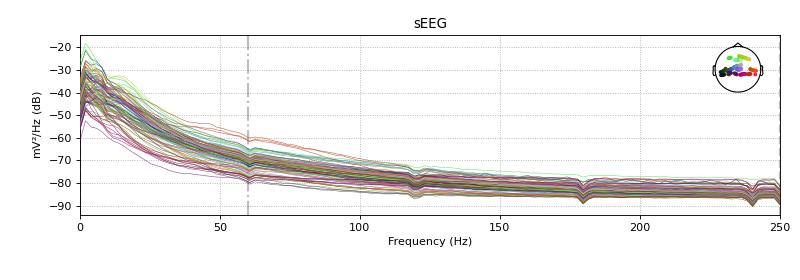

In [39]:
mne_data_bp_reref.compute_psd().plot()

### Save reref data

In [41]:
mne_data_bp_reref.save(f'{save_dir}/{subj_id}_bp_ref_ieeg.fif',overwrite=True)